In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import itertools
import time
import statsmodels.api as sm
import sys
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# df = pd.read_csv('historical_data1_time_Q12005_clean.csv')
df = pd.read_csv('data/Q12005.csv')
df2 = pd.read_csv('data/Q22005.csv')

In [23]:
y = df['curr_loan_delinquency_status']
df = df.dropna().drop(['loan_sequence_no', 'monthly_reporting_period', 
                      'curr_loan_delinquency_status'], axis=1).astype('float64')
X = df

In [24]:
y_test = df2['curr_loan_delinquency_status']
df2 = df2.dropna().drop(['loan_sequence_no', 'monthly_reporting_period', 
                      'curr_loan_delinquency_status'], axis=1).astype('float64')
X_test = df2

In [25]:
def processSubset(feature_set):
# Fit model on feature_set and calculate RSS
    model = LogisticRegression()
    model = model.fit(X[list(feature_set)], y)
    Score = model.score(X_test[list(feature_set)], y_test)
    return {"model":model, "score":Score, "feature":X_test[list(feature_set)]}

In [26]:
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        model = processSubset(predictors+[p])
        results.append(model)
        
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['score'].argmax()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    print best_model
    return best_model

models2 = pd.DataFrame(columns=["score", "model", "feature"])
tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = list(models2.loc[i]["feature"])
    
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
print predictors

('Processed ', 5, 'models on', 1, 'predictors in', 1.5592668056488037, 'seconds.')
feature            loan_age
0          108.0
1          1...
model      LogisticRegression(C=1.0, class_weight=None, d...
score                                               0.597732
Name: 1, dtype: object
('Processed ', 4, 'models on', 2, 'predictors in', 2.5891900062561035, 'seconds.')
feature            loan_age  remaining_months_to_legal_ma...
model      LogisticRegression(C=1.0, class_weight=None, d...
score                                               0.610301
Name: 1, dtype: object
('Processed ', 3, 'models on', 3, 'predictors in', 2.777255058288574, 'seconds.')
feature            loan_age  remaining_months_to_legal_ma...
model      LogisticRegression(C=1.0, class_weight=None, d...
score                                                 0.6154
Name: 1, dtype: object
('Processed ', 2, 'models on', 4, 'predictors in', 1.872075080871582, 'seconds.')
feature            loan_age  remaining_months_to_leg

In [27]:
models2

,score,model,feature
1,0.597732,"LogisticRegression(C=1.0, class_weight=None, d...",loan_age 0 108.0 1 1...
2,0.610301,"LogisticRegression(C=1.0, class_weight=None, d...",loan_age remaining_months_to_legal_ma...
3,0.615400,"LogisticRegression(C=1.0, class_weight=None, d...",loan_age remaining_months_to_legal_ma...
4,0.598827,"LogisticRegression(C=1.0, class_weight=None, d...",loan_age remaining_months_to_legal_ma...
5,0.597682,"LogisticRegression(C=1.0, class_weight=None, d...",loan_age remaining_months_to_legal_ma...


In [33]:
def getBestModel(models):
    length = len(models.index)
    bestModel = models.loc[1]
    score = models.loc[1]["score"]
    for i in range (1, length + 1):
        if models.loc[i]["score"] > score:
            bestModel = models.loc[i]
            score = models.loc[i]["score"]
    return bestModel

In [34]:
bestmodel_forward = getBestModel(models2)

# ROC curve and Confusion matrices for testing datasets

In [35]:
 y_test_predicted = bestmodel_forward["model"].predict(X_test[list(bestmodel_forward["feature"])])

In [36]:
from sklearn import metrics
conf_mat_logred = metrics.confusion_matrix(y_test, y_test_predicted)
print(conf_mat_logred)

[[184960  45401]
 [116096  73452]]


In [37]:
bestmodel_forward["model"].score(X_test[list(bestmodel_forward["feature"])], y_test)

0.61540000333405576

('Logred', '             precision    recall  f1-score   support\n\n          0       0.61      0.80      0.70    230361\n          1       0.62      0.39      0.48    189548\n\navg / total       0.62      0.62      0.60    419909\n')


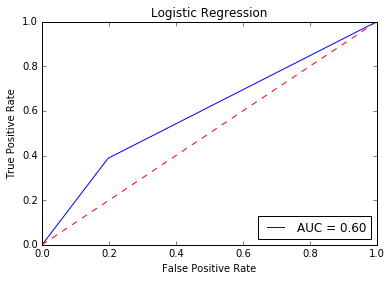

In [40]:
from sklearn import metrics
from sklearn.metrics import classification_report
from multiprocessing import Process, Lock, Manager
import matplotlib.pyplot as plt

manager = Manager()
return_dict_logred=manager.dict()
# Compute ROC curve and AUC (Area under the Curve)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    
roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)
return_dict_logred['roc_auc_logred']=roc_auc_logred
return_dict_logred['conf_mat_logred']=conf_mat_logred
    
report = classification_report(y_test, y_test_predicted)
print("Logred",report)
    
## Plot ROC Curve
plt.title("Logistic Regression")
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc_logred)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ROC curve and Confusion matrices for training datasets

In [41]:
 y_predicted = bestmodel_forward["model"].predict(X[list(bestmodel_forward["feature"])])

In [42]:
conf_mat_logred_training = metrics.confusion_matrix(y, y_predicted)
print(conf_mat_logred_training)

[[155846  39821]
 [ 89847  58540]]


In [43]:
bestmodel_forward["model"].score(X[list(bestmodel_forward["feature"])], y)

0.62311730135385723

('Logred', '             precision    recall  f1-score   support\n\n          0       0.63      0.80      0.71    195667\n          1       0.60      0.39      0.47    148387\n\navg / total       0.62      0.62      0.61    344054\n')


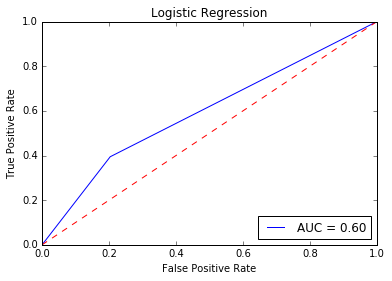

In [44]:
from sklearn import metrics
from sklearn.metrics import classification_report
from multiprocessing import Process, Lock, Manager
import matplotlib.pyplot as plt

manager = Manager()
return_dict_logred=manager.dict()
# Compute ROC curve and AUC (Area under the Curve)
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y, y_predicted)
    
roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)
return_dict_logred['roc_auc_logred']=roc_auc_logred
return_dict_logred['conf_mat_logred']=conf_mat_logred
    
report = classification_report(y, y_predicted)
print("Logred",report)
    
## Plot ROC Curve
plt.title("Logistic Regression")
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc_logred)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()